In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.nn.init as weight_init
from torch.utils.data import Dataset, DataLoader
import copy
import os
import math
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from collections import deque
# import ipdb

from environment.stockTradingEnv import stockTrading

from tqdm import tqdm
import datetime

### DQN

In [2]:
class Network(nn.Module):
    def __init__(self, state_size, action_size):
        super(Network, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(state_size, 256),
            nn.LeakyReLU(),
            nn.Dropout(0.1),

            nn.Linear(256, 16),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(16, action_size)
        )

    def forward(self, x):
        x = self.layers(x)
        return x

### Replay Memory

In [3]:
# replay memory for the experience replay
# agent's memory samples will be randomly chosen from the replay memory to train the policy network
# experience replay allows for better gradient descent performance

from collections import namedtuple
Transition = namedtuple('Transition',
                        ('state', 'action', 'reward', 'next_state'))

class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([],maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
BATCH_SIZE = 64                   
EPSILON = 1.0
EPSILON_MIN = 0.1
EPSILON_DECAY = 40000
GAMMA = 0.4                    
TARGET_REPLACE_ITR = 10 # T                      
MEMORY_CAPACITY = 30000

### Load Data

In [21]:
# load data
# change csv as necessary, e.g., 'AMZN.csv' is for analyzing Amazon's stock
raw_data = pd.read_csv('stocks.csv')
n_features = len(raw_data.columns) - 4
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# parameters
batch_size = 64
lookback_period = 5
prediction_period = 5


scaled_data = raw_data.iloc[:, 1:].apply(lambda x : (x - min(x)) / (max(x) - min(x)))

# range choices for train-test split

end = int(len(scaled_data) * 0.085)

x_train = scaled_data.iloc[:-end]
stock_closeValues_train = raw_data['Adj Close'].iloc[:-end]

x_valid = scaled_data.iloc[-end:].reset_index(drop=True)
stock_closeValues_valid = raw_data['Adj Close'].iloc[-end:].reset_index(drop=True)

options = pd.read_csv('options.csv')
options= options[['Date','Open','High','Low','Close','Volume']]
options_scaled = options.iloc[:, 1:].apply(lambda x : (x - min(x)) / (max(x) - min(x)))
options_CloseValues = options['Close']



### DQN Agent

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Agent:
    def __init__(self, state_size):
        self.state_size = state_size # number of previous days * number of features
        self.step = 0
        self.action_size = 3 # buy, sell, hold
        self.memory = ReplayMemory(MEMORY_CAPACITY) 
        self.epsilon = EPSILON
        self.epsilon_min = EPSILON_MIN
        self.epsilon_decay = EPSILON_DECAY
        self.policy_net = Network(state_size, self.action_size).to(device)
        self.target_net = Network(state_size, self.action_size).to(device)
        
        self.target_net.eval() # fix the target net
        self.target_net.load_state_dict(self.policy_net.state_dict())

        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=1e-3)
        self.scheduler = optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=EPISODES)


    def act(self, state, hold_num, is_train=True):
        self.step += 1
        
        # calculate the epsilon threshold
        # epsilon decays as more steps are completed
        eps_threshold = self.epsilon_min + (self.epsilon - self.epsilon_min) * math.exp(-1. * self.step / self.epsilon_decay)
        
        # the agent will randomly select an action in the possiblility of epsilon
        if is_train and np.random.rand() <= eps_threshold:
            action_space = [0, 1, 2]
            return torch.tensor([random.sample(action_space, 1)], device=device)
        
        # the agent will choose action based on the output of the policy net with 1-epsilon possibility
        with torch.no_grad():
            if is_train == False:
                self.policy_net.eval()
            options = self.policy_net(state)
            if is_train:
                self.policy_net.train()

        best_option = options[0]
    
        return options.max(1)[1].view(1, 1)


    def optimize(self, train=True):
        if len(self.memory) < BATCH_SIZE:
            return

        if train:
            self.policy_net.train()
        else:
            self.policy_net.eval()

        transitions = self.memory.sample(BATCH_SIZE)
        

        batch = Transition(*zip(*transitions))

        
        # calculate a mask for non-final states & concatenate batches
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device)
        non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

        
        state_batch = torch.cat([s for s in batch.state])
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)
       

        state_action_values = self.policy_net(state_batch).gather(1, action_batch)
        
        next_state_values = torch.zeros(BATCH_SIZE, device=device)
        
        # Compute all next states
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_net(non_final_next_states).max(1)[0].detach()

        # Compute the expected Q values based on the target net
        expected_state_action_values = (next_state_values * GAMMA) + reward_batch
        
        # Compute Huber loss
        loss = 0
        if train:
            # criterion = nn.MSELoss()
            # loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))
            loss = F.smooth_l1_loss(state_action_values.float(), expected_state_action_values.unsqueeze(1).float())
            
            # Optimize the model
            loss.backward()

            self.optimizer.step()
            self.optimizer.zero_grad()
            self.scheduler.step()
        return loss, float(self.optimizer.param_groups[0]['lr'])

### Train Setup

In [7]:
def game_step(observation, env, step=None, train=True):

    
    # agent takes action based on observation 
    action = agent.act(observation, env.hold_num, train)

    # after taking the action, observing the next observation and reward
    observation_, reward, done, truncate, info = env.step(action)

    
    reward = torch.tensor([reward], device=device)
    
    # push memory to replay memory
    if train:
        agent.memory.push(observation, action, reward, observation_)
        
    loss = 0
    lr = 0
    
    if step and (step >= BATCH_SIZE) and (step % 5 == 0):
        loss, lr = agent.optimize(train)

    # swap observation
    observation = observation_
    
    return observation, done, loss, lr
    

def run(sharpe_matrix, epoch):
    max_profit = -99999999
    best_loss = 99999999
    step = 0

    for episode in range(EPISODES):
        
        # initial observation
        observation, info = env.reset()
        done = False
        total_loss = 0
        
        while not done:
            observation, done, loss, lr = game_step(observation, env, step=step)
            total_loss += loss
            if not done:
                step += 1
                
        if env.total_profit > max_profit:
            torch.save(agent.policy_net.state_dict(), 'best_model')
            max_profit = env.total_profit
        
        daily_ret = env.daily_return_account
        daily_ret = np.array(daily_ret)
        sharpe = np.mean(daily_ret) / np.std(daily_ret) * (252 ** 0.5)
        
        sharpe_matrix[epoch][episode] = sharpe # for plotting performance graphs over episodes
        
        print('episode:%d, total_profit:%.3f, sharpe:%.3f' % (episode, env.total_profit, sharpe))
        
        if episode % TARGET_REPLACE_ITR == 0:
            agent.target_net.load_state_dict(agent.policy_net.state_dict())
    
    return sharpe_matrix

def BackTest():
    # validation
    env_val = stockTrading(x_valid, 
                           stock_closeValues_valid,
                           lookback_period = LOOKBACK_PERIODS)
    observation, info = env_val.reset()

    agent.policy_net.load_state_dict(torch.load('best_model'))
    while True:
        observation, done, _, _ = game_step(observation, env_val, train=False)
        if done:
            break
    print('total_profit:%.3f' % (env_val.total_profit))
    return env_val

### Train and Validation

5
episode:0, total_profit:400853.521, sharpe:0.193
episode:1, total_profit:8562729.338, sharpe:0.541
episode:2, total_profit:19514305.371, sharpe:0.656
episode:3, total_profit:2348994.531, sharpe:0.348
episode:4, total_profit:18480334.048, sharpe:0.624
episode:5, total_profit:71195779.576, sharpe:0.833
episode:6, total_profit:6278447.643, sharpe:0.467
episode:7, total_profit:3488433.499, sharpe:0.395
episode:8, total_profit:1485698.958, sharpe:0.299
episode:9, total_profit:5176776.645, sharpe:0.451
episode:10, total_profit:19522218.775, sharpe:0.653
episode:11, total_profit:20588441.692, sharpe:0.658
episode:12, total_profit:31238229.541, sharpe:0.726
episode:13, total_profit:10369875.436, sharpe:0.546
episode:14, total_profit:12389703.460, sharpe:0.572
episode:15, total_profit:183057835.130, sharpe:0.997
episode:16, total_profit:43548829.504, sharpe:0.761
episode:17, total_profit:14523482.952, sharpe:0.589
episode:18, total_profit:23526205.064, sharpe:0.661
episode:19, total_profit:50

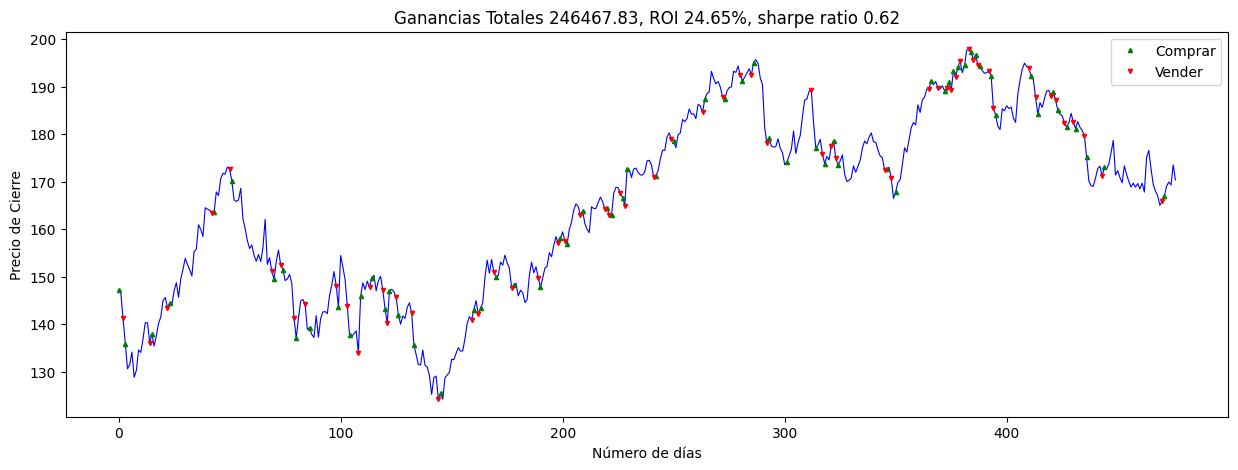

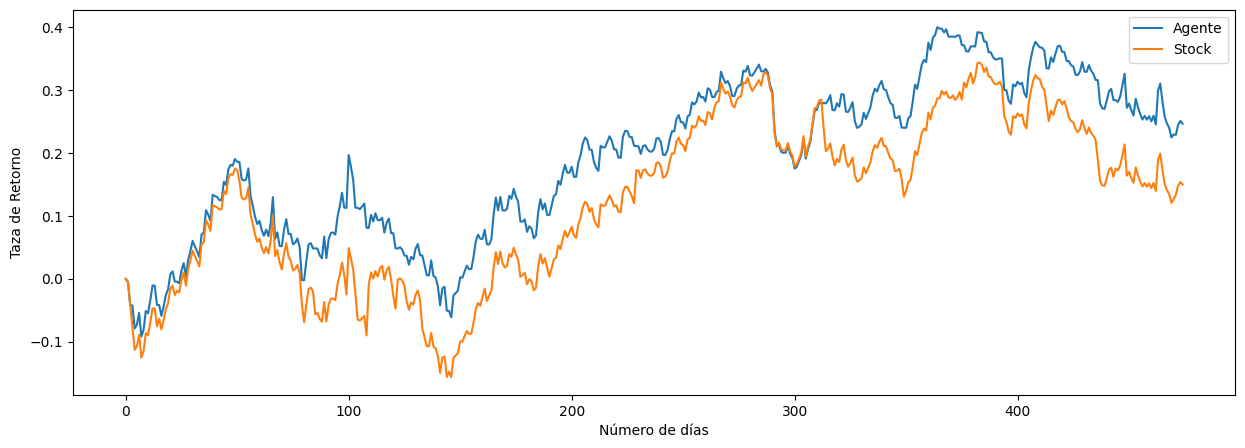

episode:0, total_profit:4895898.921, sharpe:0.464
episode:1, total_profit:13391626.314, sharpe:0.613
episode:2, total_profit:1584390.783, sharpe:0.306
episode:3, total_profit:46685490.775, sharpe:0.792
episode:4, total_profit:33865039.788, sharpe:0.730
episode:5, total_profit:54232881.192, sharpe:0.785
episode:6, total_profit:20050482.657, sharpe:0.639
episode:7, total_profit:40852381.848, sharpe:0.763
episode:8, total_profit:33329155.933, sharpe:0.736
episode:9, total_profit:13075285.052, sharpe:0.584
episode:10, total_profit:31886591.056, sharpe:0.712
episode:11, total_profit:15872503.550, sharpe:0.603
episode:12, total_profit:70256973.869, sharpe:0.847
episode:13, total_profit:64847249.041, sharpe:0.813
episode:14, total_profit:164031444.282, sharpe:0.982
episode:15, total_profit:32129951.699, sharpe:0.712
episode:16, total_profit:17129965.714, sharpe:0.615
episode:17, total_profit:37703517.789, sharpe:0.735
episode:18, total_profit:10073461.610, sharpe:0.539
episode:19, total_profi

KeyboardInterrupt: 

In [8]:
LOOKBACK_PERIODS = 5
EPISODES = 50
EPOCHS = 50 

roi = []
sharpe = []

sharpe_matrix = np.zeros([EPOCHS, EPISODES])
scaled_data = scaled_data[['Open', 'High', 'Low', 'Adj Close', 'Volume']]
num_col = len(scaled_data.columns)
print(num_col)

for epoch in range(EPOCHS):
    env = stockTrading(x_train, 
                       stock_closeValues_train, 
                       lookback_period = LOOKBACK_PERIODS)
    agent = Agent(env.n_features)
    sharpe_matrix = run(sharpe_matrix, epoch)
    #env.draw('train_trade.png', 'train_profit.png') # optional: plot for training result
    agent.step
    
    # validation
    env_val = BackTest()
    roi.append(env_val.profit_rate_account[-1]*100)
    sharpe.append(env_val.calc_sharpe())
    env_val.render('trade1.png', 'profit1.png')

### Performance Evaluation

In [ ]:
print('Average ROI: ', (np.sort(roi)).mean())
print('Average Sharpe Ratio: ', np.sort(sharpe).mean())
print('ROI Stdev: ', np.std(roi))
print('Sharpe Ratio Stdev: ', np.std(sharpe))

In [ ]:
# View all ROI & Sharpe Ratio
np.sort(roi), np.sort(sharpe)

In [ ]:
# plot sharpe ratio performance (with error bar) for episodes
# sharpe_matrix: (EPOCH, EPISODE)
# sharpe_table = pd.DataFrame(columns=['EPOCHS', 'EPISODES', 'SHARPE'])

# for epoch in range(EPOCHS):
#     for episo in range(EPISODES):
#         row = pd.DataFrame(np.array([epoch, episo, sharpe_matrix[epoch][episo]]).reshape(1, 3), columns=['EPOCHS', 'EPISODES', 'SHARPE'])
#         sharpe_table = sharpe_table.append(pd.DataFrame(row, columns=['EPOCHS', 'EPISODES', 'SHARPE']))
# sharpe_table['EPOCHS'] = sharpe_table['EPOCHS'].astype('int64', copy=True)
# sharpe_table['EPISODES'] = sharpe_table['EPISODES'].astype('int64', copy=True)
# sharpe_table = sharpe_table.reset_index(drop=True)
# sns.set(rc={'figure.figsize':(10, 10)})
# sharpe_plot = sns.lineplot(data=sharpe_table, x='EPISODES', y='SHARPE')
# sharpe_plot

sharpe_table_data = []

for epoch in range(EPOCHS):
    for episo in range(EPISODES):
        sharpe_table_data.append({'EPOCHS': epoch, 'EPISODES': episo, 'SHARPE': sharpe_matrix[epoch][episo]})

sharpe_table = pd.DataFrame(sharpe_table_data)
sharpe_table['EPOCHS'] = sharpe_table['EPOCHS'].astype('int64')
sharpe_table['EPISODES'] = sharpe_table['EPISODES'].astype('int64')
sharpe_table = sharpe_table.reset_index(drop=True)

sns.set(rc={'figure.figsize':(10, 10)})
sharpe_plot = sns.lineplot(data=sharpe_table, x='EPISODES', y='SHARPE')

### Comparison Metrics

In [ ]:
# calculate performance for buy-and-hold strategy
bh = combined_raw_data['Adj Close'].iloc[-end:].reset_index(drop=True).values
bh_roi = bh[-1] / bh[0] - 1
bh_daily_ret = []
for i in range(len(bh) - 1):
    bh_daily_ret.append(bh[i+1] / bh[i] - 1)
bh_sharpe = np.mean(bh_daily_ret) / np.std(bh_daily_ret) * (252 ** 0.5)

print('Buy-and-Hold ROI:', bh_roi * 100)
print('Buy-and-Hold Sharpe Ratio:', bh_sharpe)

In [ ]:
# calculate performance for short-and-hold strategy
sh = bh
sh_roi = sh[0] / sh[-1] - 1
sh_daily_ret = []
for i in range(len(sh) - 1):
    sh_daily_ret.append(sh[i] / sh[i+1] - 1)
sh_sharpe = np.mean(sh_daily_ret) / np.std(sh_daily_ret) * (252 ** 0.5)

print('Short-and-Hold ROI:', sh_roi * 100)
print('Short-and-Hold Sharpe Ratio:', sh_sharpe)